In [1]:

import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob
from collections import Counter

# تحميل stopwords
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/airlines-reviews/airlines_reviews.csv


In [2]:
df = pd.read_csv('/kaggle/input/airlines-reviews/airlines_reviews.csv')
print(df.head())

                                  Title              Name Review Date  \
0                    Flight was amazing  Alison Soetantyo  2024-03-01   
1  seats on this aircraft are dreadful      Robert Watson  2024-02-21   
2          Food was plentiful and tasty             S Han  2024-02-20   
3          “how much food was available          D Laynes  2024-02-19   
4       “service was consistently good”         A Othman   2024-02-19   

              Airline Verified  \
0  Singapore Airlines     True   
1  Singapore Airlines     True   
2  Singapore Airlines     True   
3  Singapore Airlines     True   
4  Singapore Airlines     True   

                                             Reviews Type of Traveller  \
0    Flight was amazing. The crew onboard this fl...      Solo Leisure   
1    Booking an emergency exit seat still meant h...      Solo Leisure   
2    Excellent performance on all fronts. I would...    Family Leisure   
3   Pretty comfortable flight considering I was f...      So

In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   8100 non-null   object
 1   Name                    8100 non-null   object
 2   Review Date             8100 non-null   object
 3   Airline                 8100 non-null   object
 4   Verified                8100 non-null   object
 5   Reviews                 8100 non-null   object
 6   Type of Traveller       8100 non-null   object
 7   Month Flown             8100 non-null   object
 8   Route                   8100 non-null   object
 9   Class                   8100 non-null   object
 10  Seat Comfort            8100 non-null   int64 
 11  Staff Service           8100 non-null   int64 
 12  Food & Beverages        8100 non-null   int64 
 13  Inflight Entertainment  8100 non-null   int64 
 14  Value For Money         8100 non-null   int64 
 15  Over

In [4]:
print(df.isna().sum())

Title                     0
Name                      0
Review Date               0
Airline                   0
Verified                  0
Reviews                   0
Type of Traveller         0
Month Flown               0
Route                     0
Class                     0
Seat Comfort              0
Staff Service             0
Food & Beverages          0
Inflight Entertainment    0
Value For Money           0
Overall Rating            0
Recommended               0
dtype: int64


In [5]:
print(df.shape)
print(df.columns)

(8100, 17)
Index(['Title', 'Name', 'Review Date', 'Airline', 'Verified', 'Reviews',
       'Type of Traveller', 'Month Flown', 'Route', 'Class', 'Seat Comfort',
       'Staff Service', 'Food & Beverages', 'Inflight Entertainment',
       'Value For Money', 'Overall Rating', 'Recommended'],
      dtype='object')


In [6]:
# تنظيف النصوص
def clean_text(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.lower()
    stop = set(stopwords.words('english'))
    words = [w for w in text.split() if w not in stop and len(w) > 2]  # استبعاد الكلمات القصيرة
    return " ".join(words)

df["Clean_Review"] = df["Reviews"].apply(clean_text)

In [7]:
# تحليل المشاعر
def get_sentiment(text):
    if text.strip() == "":
        return "Neutral"
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["Clean_Review"].apply(get_sentiment)
df["Sentiment_Score"] = df["Clean_Review"].apply(lambda x: TextBlob(x).sentiment.polarity)


In [8]:
# إنشاء ملف Word Cloud بعدد التكرارات
wordcloud_data = []

for airline_name, group in df.groupby('Airline'):
    # لكل نوع من المشاعر
    for sentiment_type in ['Positive', 'Negative', 'Neutral']:
        reviews = group[group['Sentiment'] == sentiment_type]['Clean_Review']
        all_words = " ".join(reviews).split()
        word_counts = Counter(all_words)
        
        # حفظ كل كلمة مع عدد تكرارها
        for word, count in word_counts.items():
            wordcloud_data.append({
                'Airline': airline_name,
                'Sentiment': sentiment_type,
                'Word': word,
                'Count': count
            })

# تحويل إلى DataFrame
wordcloud_df = pd.DataFrame(wordcloud_data)

# ترتيب حسب التكرار
wordcloud_df = wordcloud_df.sort_values(['Airline', 'Sentiment', 'Count'], ascending=[True, True, False])

# حفظ ملف Word Cloud
wordcloud_df.to_csv('wordcloud_data.csv', index=False)

In [9]:
# إنشاء ملف منفصل لأعلى 50 كلمة لكل شركة ومشاعر (اختياري)
top_words_summary = []
for (airline, sentiment), group in wordcloud_df.groupby(['Airline', 'Sentiment']):
    top_50 = group.head(50)
    top_words_summary.append({
        'Airline': airline,
        'Sentiment': sentiment,
        'Top_Words': ', '.join(top_50['Word'].tolist()),
        'Top_Counts': ', '.join(top_50['Count'].astype(str).tolist())
    })

top_summary_df = pd.DataFrame(top_words_summary)
top_summary_df.to_csv('top_50_words_summary.csv', index=False)

# حفظ الملف الأصلي مع البيانات الإضافية
df["Review Date"] = pd.to_datetime(df["Review Date"], errors="coerce")
df["Year"] = df["Review Date"].dt.year
df["Month"] = df["Review Date"].dt.month_name()

df.to_csv('Airline_reviews_processed.csv', index=False)

print("✅ تم إنشاء 3 ملفات:")
print("1. wordcloud_data.csv - كل الكلمات مع عدد التكرار (جاهز لـ word cloud)")
print("2. top_50_words_summary.csv - ملخص أعلى 50 كلمة")
print("3. Airline_reviews_processed.csv - الملف الأصلي المعالج")
print(f"\n📊 إجمالي الكلمات المستخرجة: {len(wordcloud_df):,}")
print(f"📊 عدد الشركات: {df['Airline'].nunique()}")

✅ تم إنشاء 3 ملفات:
1. wordcloud_data.csv - كل الكلمات مع عدد التكرار (جاهز لـ word cloud)
2. top_50_words_summary.csv - ملخص أعلى 50 كلمة
3. Airline_reviews_processed.csv - الملف الأصلي المعالج

📊 إجمالي الكلمات المستخرجة: 90,040
📊 عدد الشركات: 10


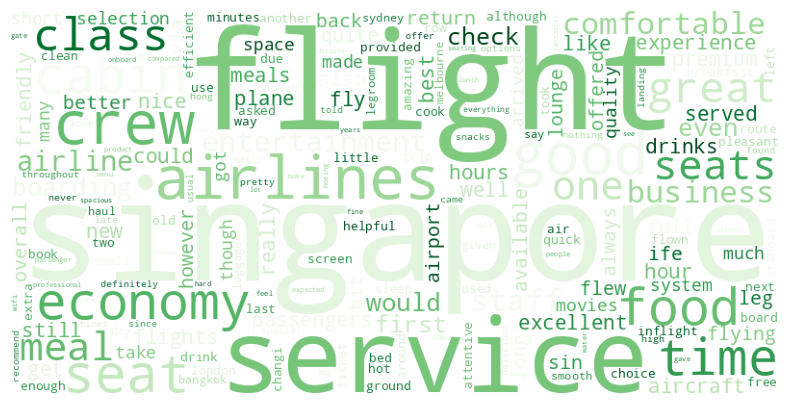

In [10]:
# مثال بسيط
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# اختر شركة ومشاعر
airline = "Singapore Airlines"
sentiment = "Positive"

# فلتر البيانات
data = wordcloud_df[(wordcloud_df['Airline']==airline) & (wordcloud_df['Sentiment']==sentiment)]
word_freq = dict(zip(data['Word'], data['Count']))

# أنشئ Word Cloud
wc = WordCloud(width=800, height=400,
    colormap='Greens',  # تدرجات اللون الأخضر
    background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()

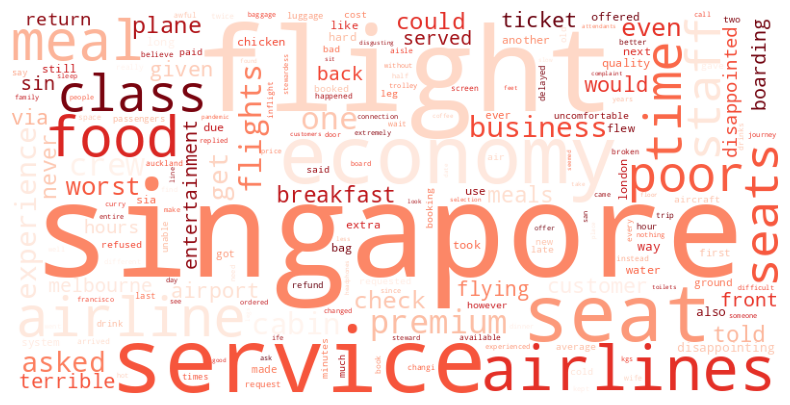

In [11]:

# اختر شركة ومشاعر
airline = "Singapore Airlines"
sentiment = "Negative"

# فلتر البيانات
data = wordcloud_df[(wordcloud_df['Airline']==airline) & (wordcloud_df['Sentiment']==sentiment)]
word_freq = dict(zip(data['Word'], data['Count']))

# أنشئ Word Cloud
wc = WordCloud(width=800, height=400,
    colormap='Reds',  # تدرجات اللون الأحمر
    background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(10,5))
plt.imshow(wc)
plt.axis('off')
plt.show()